In [1]:
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# read json data file
datastore = []
for line in open("data/Sarcasm_Headlines_Dataset.json", 'r'):
    datastore.append(json.loads(line))
print("datastore size: " + str(len(datastore)))

datastore size: 26709


In [8]:
# copy headlines and is_sarcastic data into sentences and labels lists
sentences = []
labels = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [67]:
# split sentences and labels into training and test datasets
training_size = int(len(datastore) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [68]:
oov_tok = "<OOV>"

# oov = out of vocabulary, 
# words that are not in tokenizer's vocabulary are tagged as '<oov>'
# if oov_token is not specified, unseen words would not be mentioned in sequence
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [69]:
word_index_dict = tokenizer.word_index
vocab_size = len(word_index_dict)
print("vocab_size: " + str(len(word_index_dict)))

# print a few items in word_index_dict to see the tokens
for item in list(word_index_dict.items())[0:10]:
    print(item)

vocab_size: 26507
('<OOV>', 1)
('to', 2)
('of', 3)
('the', 4)
('in', 5)
('for', 6)
('a', 7)
('on', 8)
('and', 9)
('with', 10)


mean training sequence length: 10.04076379463659
max training sequence length: 40


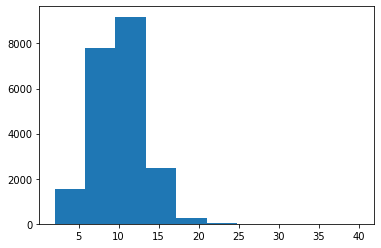

In [70]:
import statistics

# using the word_index fitted from sentences 
# converts the sentences into sequence of indecies  
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# let's look at the length distribution of training sequence length
# this can give us an idea for maxlen parameter when we pad the sequence
seq_lengths = []
for seq in training_sequences:
    seq_lengths.append(len(seq))
    
mean_len = statistics.mean(seq_lengths)
max_len = max(seq_lengths)
print("mean training sequence length: " + str(mean_len))
print("max training sequence length: " + str(max_len))

plt.hist(seq_lengths)
plt.show()

In [71]:
max_length = 20
trunc_type='post'
padding_type='post'

# applies padding with 0's to make all sequences equal in length
# the output is a matrix with padded sequences in each row 
# by default keras adds the padding at beginning of sequence
# can put the padding at the end by using padding='post' parameter
# can also specify the length of all sequences and truncate longer ones using maxlen=N
# and truncating to specify where to trauncate from (beginning or end)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(training_sequences[87])
print(training_padded[87])
print(training_padded.shape)

[13384, 9304, 108, 7, 13385, 3606, 16, 814, 13386, 815]
[13384  9304   108     7 13385  3606    16   814 13386   815     0     0
     0     0     0     0     0     0     0     0]
(21367, 20)


In [86]:
# define model
embedding_dim = 16
drop_rate = 0.4

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
        tf.keras.layers.Dropout(drop_rate),
        tf.keras.layers.Conv1D(32, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),   
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),    
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 16)            424128    
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 32)            2592      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 4, 32)             0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                16640     
_________________________________________________________________
dense_20 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [87]:
# train model

num_epochs = 10

# convert lists into numpy arrays for training
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Train on 21367 samples, validate on 5342 samples
Epoch 1/10
21367/21367 [==============================] - 21s 990us/sample - loss: 0.4558 - accuracy: 0.7675 - val_loss: 0.3446 - val_accuracy: 0.8491
Epoch 2/10
21367/21367 [==============================] - 15s 725us/sample - loss: 0.2396 - accuracy: 0.9035 - val_loss: 0.3523 - val_accuracy: 0.8472
Epoch 3/10
21367/21367 [==============================] - 17s 787us/sample - loss: 0.1467 - accuracy: 0.9444 - val_loss: 0.3689 - val_accuracy: 0.8555
Epoch 4/10
21367/21367 [==============================] - 18s 848us/sample - loss: 0.0932 - accuracy: 0.9663 - val_loss: 0.4200 - val_accuracy: 0.8474
Epoch 5/10
21367/21367 [==============================] - 18s 845us/sample - loss: 0.0604 - accuracy: 0.9785 - val_loss: 0.4958 - val_accuracy: 0.8439
Epoch 6/10
21367/21367 [==============================] - 16s 766us/sample - loss: 0.0444 - accuracy: 0.9844 - val_loss: 0.5219 - val_accuracy: 0.8452
Epoch 7/10
21367/21367 [=====================

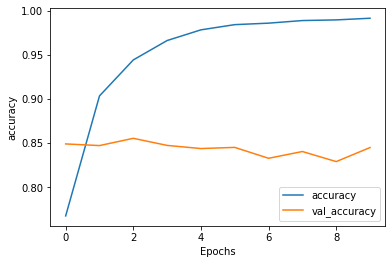

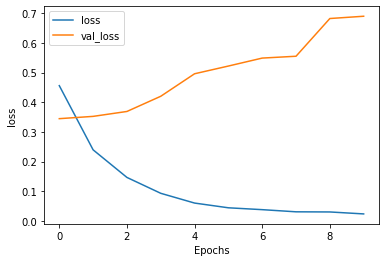

In [88]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Looking at the plots, there is a noticable difference between the training and validation accuracy. The training is near 100% but validation accuracy stays flat around 80%. Also, the validation loss is increasing while the training loss is reduced to near zero. Clearly, we have overfitting.

We can use early stopping to monitor our validation loss. If a set amount of epochs elapses without showing improvement, automatically stop the training. 

Train on 21367 samples, validate on 5342 samples
Epoch 1/10
21367/21367 [==============================] - 21s 978us/sample - loss: 0.4614 - accuracy: 0.7627 - val_loss: 0.3421 - val_accuracy: 0.8495
Epoch 2/10
21367/21367 [==============================] - 16s 731us/sample - loss: 0.2408 - accuracy: 0.9036 - val_loss: 0.3347 - val_accuracy: 0.8579
Epoch 3/10
21367/21367 [==============================] - 16s 730us/sample - loss: 0.1503 - accuracy: 0.9439 - val_loss: 0.3500 - val_accuracy: 0.8527
Epoch 4/10
21367/21367 [==============================] - 15s 723us/sample - loss: 0.0939 - accuracy: 0.9662 - val_loss: 0.3998 - val_accuracy: 0.8502


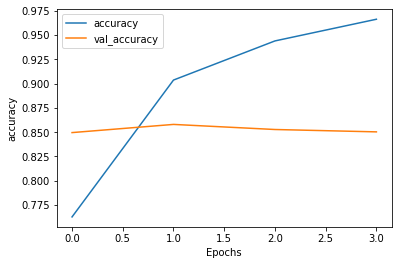

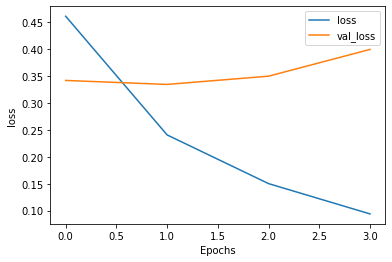

In [89]:
model = build_model()

# The patience parameter is the number of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), verbose=1, callbacks=[early_stop])

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')